## Provided Datasets

### Cross-reference files

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display # Allows the use of display() for DataFrames

shops = pd.read_csv('data/provided/shops.csv', index_col=1)
print('number of shops:', len(shops))
shops.head()

number of shops: 60


,shop_name
shop_id,
0,"!Якутск Орджоникидзе, 56 фран"
1,"!Якутск ТЦ ""Центральный"" фран"
2,"Адыгея ТЦ ""Мега"""
3,"Балашиха ТРК ""Октябрь-Киномир"""
4,"Волжский ТЦ ""Волга Молл"""


In [2]:
categs = pd.read_csv('data/provided/item_categories.csv', index_col=1)
print('number of categories:', len(categs))
categs.head()

number of categories: 84


,item_category_name
item_category_id,
0,PC - Гарнитуры/Наушники
1,Аксессуары - PS2
2,Аксессуары - PS3
3,Аксессуары - PS4
4,Аксессуары - PSP


In [3]:
items = pd.read_csv('data/provided/items.csv', index_col=1)
print('number of items:', len(items))
items.head()

number of items: 22170


,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


### Transactions file

In [4]:
transactions = pd.read_csv('data/provided/sales_train_v2.csv')
print('number of records:', len(transactions))
print('max date_block_num:', transactions['date_block_num'].max())
transactions.head()

number of records: 2935849
max date_block_num: 33


,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


### Test file

In [5]:
test_data = pd.read_csv('data/provided/test.csv', index_col=0)
print("number of predictions to make:", len(test_data))
test_data.head()

number of predictions to make: 214200


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


## Data Analysis
Let's aggregate the daily records so we can have a look at the distribution of the monthly counts for each item and shop pairing.

In [6]:
monthly_totals = transactions.groupby(['date_block_num', 'shop_id', 'item_id'],as_index=False)[['item_cnt_day']].sum()
monthly_totals['item_cnt_day'].describe()

count    1.609124e+06
mean     2.267200e+00
std      8.649882e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.253000e+03
Name: item_cnt_day, dtype: float64

How many montlhy records have a negative value in the item_cnt_day field?

In [7]:
negative_counts = monthly_totals.loc[monthly_totals['item_cnt_day'] < 0]['item_cnt_day']
negative_counts.describe()

count    915.000000
mean      -1.080874
std        0.852346
min      -22.000000
25%       -1.000000
50%       -1.000000
75%       -1.000000
max       -1.000000
Name: item_cnt_day, dtype: float64

In [8]:
shop_item_totals_by_month = pd.pivot_table(monthly_totals, values=['item_cnt_day'], index=['shop_id','item_id'], columns=['date_block_num'], aggfunc=np.sum)
shop_item_totals_by_month.fillna(0.0, inplace=True)
shop_item_totals_by_month.head()

item_cnt_day                                                \
date_block_num            0     1    2    3    4    5    6    7    8    9    
shop_id item_id                                                              
0       30               0.0  31.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        31               0.0  11.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        32               6.0  10.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        33               3.0   3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
        35               1.0  14.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                ...                                                     
date_block_num  ...    24   25   26   27   28   29   30   31   32   33  
shop_id item_id ...                                                     
0       30      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        31      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        32      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        33      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
        35      ...   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[5 rows x 34 columns]

### Correlation between sales among months

In [9]:
def get_shifted_monthly_totals(df, month_idx):
    totals = df.copy()
    totals['date_block_num'] = totals['date_block_num'] - month_idx
    return totals

In [10]:
item_sales_data = monthly_totals.copy()
item_sales_data.rename(index=str, columns={"item_cnt_day":"t"}, inplace=True)
item_sales_data.head()

,date_block_num,shop_id,item_id,t
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [11]:
prior_totals = get_shifted_monthly_totals(monthly_totals, -1)
item_sales_data = item_sales_data.merge(prior_totals, on=['date_block_num', 'shop_id', 'item_id'], how='left')
item_sales_data.rename(index=str, columns={"item_cnt_day":"tm1"}, inplace=True)

prior_totals = get_shifted_monthly_totals(monthly_totals, -2)
item_sales_data = item_sales_data.merge(prior_totals, on=['date_block_num', 'shop_id', 'item_id'], how='left')
item_sales_data.rename(index=str, columns={"item_cnt_day":"tm2"}, inplace=True)

prior_totals = get_shifted_monthly_totals(monthly_totals, -3)
item_sales_data = item_sales_data.merge(prior_totals, on=['date_block_num', 'shop_id', 'item_id'], how='left')
item_sales_data.rename(index=str, columns={"item_cnt_day":"tm3"}, inplace=True)

prior_totals = get_shifted_monthly_totals(monthly_totals, -6)
item_sales_data = item_sales_data.merge(prior_totals, on=['date_block_num', 'shop_id', 'item_id'], how='left')
item_sales_data.rename(index=str, columns={"item_cnt_day":"tm6"}, inplace=True)

prior_totals = get_shifted_monthly_totals(monthly_totals, -12)
item_sales_data = item_sales_data.merge(prior_totals, on=['date_block_num', 'shop_id', 'item_id'], how='left')
item_sales_data.rename(index=str, columns={"item_cnt_day":"tm12"}, inplace=True)

item_sales_data.head()

,date_block_num,shop_id,item_id,t,tm1,tm2,tm3,tm6,tm12
0,0,0,32,6.0,NaN,NaN,NaN,NaN,NaN
1,0,0,33,3.0,NaN,NaN,NaN,NaN,NaN
2,0,0,35,1.0,NaN,NaN,NaN,NaN,NaN
3,0,0,43,1.0,NaN,NaN,NaN,NaN,NaN
4,0,0,51,2.0,NaN,NaN,NaN,NaN,NaN


In [12]:
item_sales_data = item_sales_data.loc[(item_sales_data['date_block_num'] > 11)]
item_sales_data.drop(['date_block_num','shop_id','item_id'], axis=1, inplace=True)
item_sales_data.fillna(0.0, inplace=True)
item_sales_data.head()

,t,tm1,tm2,tm3,tm6,tm12
687724,1.0,0.0,0.0,0.0,0.0,0.0
687725,1.0,1.0,2.0,0.0,0.0,1.0
687726,1.0,0.0,0.0,0.0,0.0,0.0
687727,2.0,1.0,2.0,1.0,1.0,1.0
687728,1.0,1.0,0.0,4.0,2.0,0.0


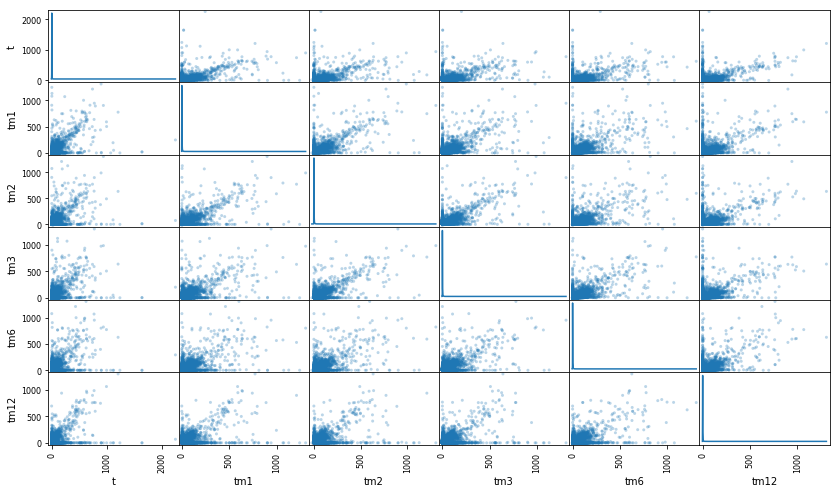

In [29]:
#Plot scatter matrix to look at correlation between counts in different months
pd.plotting.scatter_matrix(item_sales_data, alpha = 0.3, figsize = (12,12), diagonal = 'hist');

It looks like there is some correction between sales total in the current month and the sales total for the prior month, two months ago, three months ago and a year ago.

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(item_sales_data)
scaled_data = scaler.transform(item_sales_data)
scaled_data_df = pd.DataFrame(data=scaled_data)

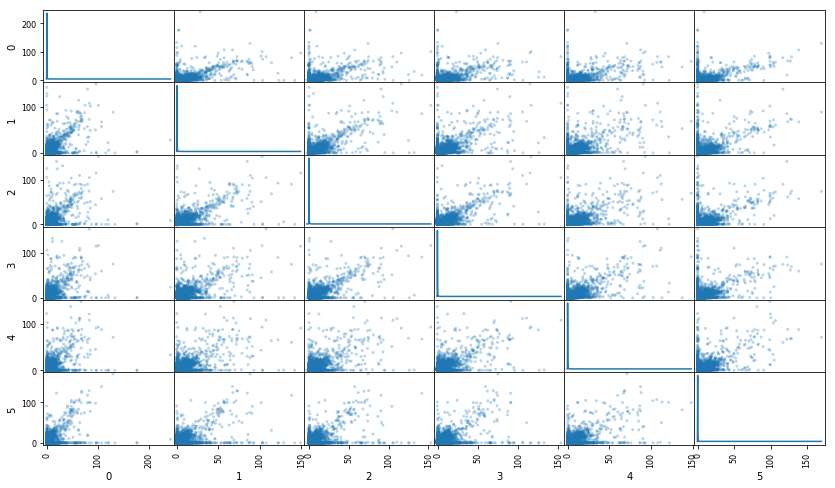

In [33]:
pd.plotting.scatter_matrix(scaled_data_df, alpha = 0.3, figsize = (12,12), diagonal = 'hist');

Does the sales count of items sold at a shop have a correlation with the sales of count of the category of the items shop at the same shop?

In [13]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def pca_results(good_data, pca):
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = list(good_data.keys()))
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    # Create a bar plot visualization
    fig, ax = plt.subplots(figsize = (14,8))

    # Plot the feature weights as a function of the components
    components.plot(ax = ax, kind = 'bar');
    ax.set_ylabel("Feature Weights")
    ax.set_xticklabels(dimensions, rotation=0)

    # Display the explained variance ratios
    for i, ev in enumerate(pca.explained_variance_ratio_):
        ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Expl. Var.\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)

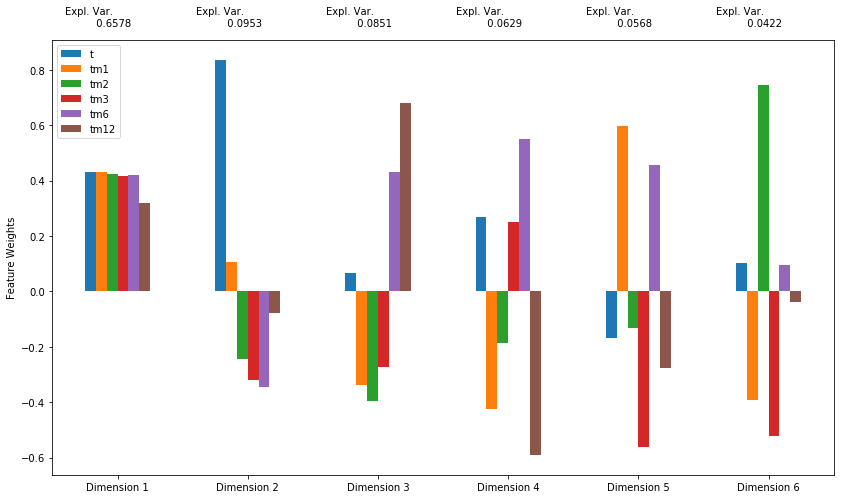

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(item_sales_data)

pca_results = pca_results(item_sales_data, pca)

### Shops

In [15]:
monthly_shop_totals = monthly_totals.groupby(['date_block_num', 'shop_id'],as_index=False)[['item_cnt_day']].sum()
monthly_shop_totals.head()

,date_block_num,shop_id,item_cnt_day
0,0,0,5578.0
1,0,1,2947.0
2,0,2,1146.0
3,0,3,767.0
4,0,4,2114.0


In [16]:
monthly_shop_totals['item_cnt_day'].describe()

count     1586.00000
mean      2300.25599
std       1906.64723
min         -1.00000
25%       1185.25000
50%       1737.50000
75%       2599.00000
max      16318.00000
Name: item_cnt_day, dtype: float64

In [17]:
shop_totals_all_months = monthly_shop_totals.pivot(index='shop_id', columns='date_block_num', values='item_cnt_day')
shop_totals_all_months.fillna(0.0, inplace=True)
shop_totals_all_months.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
shop_id,,,,,,,,,,,,,,,,,,,,,
0,5578.0,6127.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2947.0,3364.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1146.0,488.0,753.0,583.0,553.0,832.0,807.0,875.0,945.0,795.0,...,987.0,907.0,762.0,859.0,843.0,804.0,785.0,942.0,822.0,727.0
3,767.0,798.0,959.0,647.0,710.0,784.0,721.0,890.0,1026.0,793.0,...,977.0,738.0,741.0,740.0,731.0,672.0,535.0,666.0,745.0,613.0
4,2114.0,2025.0,2060.0,285.0,1211.0,1464.0,1378.0,1713.0,1536.0,1482.0,...,1188.0,980.0,978.0,899.0,893.0,793.0,842.0,947.0,732.0,831.0


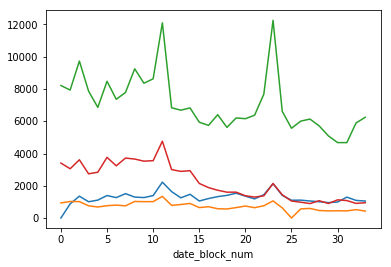

In [45]:
#plot sales by month to see any cyclical sales pattern
shop_totals_all_months.loc[5].plot.line()
shop_totals_all_months.loc[10].plot.line()
shop_totals_all_months.loc[25].plot.line()
shop_totals_all_months.loc[50].plot.line()

In [20]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

def get_clusterer(data, n):
    clusterer = GaussianMixture(n_components=n)
    clusterer.fit(data)

    preds = clusterer.predict(data)
    centers = clusterer.means_
    score = silhouette_score(data, preds)
    print("n={}: score: {}".format(n, score))
    return clusterer, score, preds 

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(shop_totals_all_months)
scaled_shop_data = scaler.transform(shop_totals_all_months)

for n in range(2, 12):   
    get_clusterer(shop_totals_all_months, n)

n=2: score: 0.6829974850566602
n=3: score: 0.4494084245697172
n=4: score: 0.4397424983061118
n=5: score: 0.43412996096317075
n=6: score: 0.26418612406437136
n=7: score: 0.24240381046413026
n=8: score: 0.3000314110221993
n=9: score: 0.2938193291384627
n=10: score: 0.26873786396465815
n=11: score: 0.260689874615943


### Categories

In [24]:
monthly_categ_totals = monthly_totals.merge(items, on=['item_id'], how='left').drop(['item_name'], axis=1)
monthly_categ_totals = monthly_categ_totals.groupby(['date_block_num', 'item_category_id'],as_index=False)[['item_cnt_day']].sum()
monthly_categ_totals.head()

,date_block_num,item_category_id,item_cnt_day
0,0,0,1.0
1,0,1,1.0
2,0,2,1390.0
3,0,3,440.0
4,0,4,251.0


In [25]:
monthly_categ_totals['item_cnt_day'].describe()

count     2077.000000
mean      1756.478575
std       3669.113351
min         -1.000000
25%        145.000000
50%        514.000000
75%       1323.000000
max      36277.000000
Name: item_cnt_day, dtype: float64

In [26]:
categ_totals_all_months = monthly_categ_totals.pivot(index='item_category_id', columns='date_block_num', values='item_cnt_day')
categ_totals_all_months.fillna(0.0, inplace=True)
categ_totals_all_months.head()

date_block_num,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
item_category_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1390.0,1190.0,1025.0,646.0,596.0,667.0,618.0,674.0,792.0,790.0,...,370.0,307.0,229.0,170.0,146.0,104.0,114.0,132.0,89.0,82.0
3,440.0,302.0,293.0,202.0,146.0,150.0,233.0,300.0,383.0,391.0,...,1398.0,834.0,773.0,746.0,667.0,559.0,603.0,975.0,1090.0,1059.0
4,251.0,220.0,226.0,160.0,175.0,176.0,179.0,140.0,86.0,89.0,...,10.0,2.0,2.0,2.0,2.0,1.0,0.0,1.0,0.0,0.0


In [27]:
def get_quarterly_counts(totals, date_blocks):
    yr_label = '2013'
    qtr_label = 'q1'
    for x in range(0, date_blocks, 3):
        if x >= 24:
            yr_label = '2015'
        elif x >= 12:
            yr_label = '2014'
        
        if (x % 12) < 3:
            qtr_label = 'q1'
        elif (x % 12) <6:
            qtr_label = 'q2'
        elif (x % 12) <9:
            qtr_label = 'q3'
        else:
            qtr_label = 'q4'

        lbl = yr_label + qtr_label
        totals[lbl] = totals[x] + totals[x+1] + totals[x+2]

In [31]:
#sum up quarterly totals
get_quarterly_counts(categ_totals_all_months, 33)
categ_totals_all_qtrs = categ_totals_all_months[['2013q1','2013q2','2013q3','2013q4','2014q1','2014q2','2014q3','2014q4','2015q1','2015q2','2015q3']]
categ_totals_all_qtrs.head()

date_block_num,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
item_category_id,,,,,,,,,,,
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3605.0,1909.0,2084.0,3741.0,2726.0,1439.0,1048.0,1302.0,906.0,420.0,335.0
3,1035.0,498.0,916.0,4139.0,4229.0,2240.0,3337.0,4709.0,3005.0,1972.0,2668.0
4,697.0,511.0,405.0,284.0,200.0,132.0,102.0,56.0,14.0,5.0,1.0


In [32]:
scaler.fit(categ_totals_all_qtrs)
scaled_data = scaler.transform(categ_totals_all_qtrs)

for n in range(2, 12):
    get_clusterer(scaled_data, n)

n=2: score: 0.8508244422804313
n=3: score: 0.8275288357830968
n=4: score: 0.8138174504099983
n=5: score: 0.36811358842843317
n=6: score: 0.3622003115818001
n=7: score: 0.4431016767094475
n=8: score: 0.41199485511949807
n=9: score: 0.3600698372020415
n=10: score: 0.42405394214123815
n=11: score: 0.4171732833109863


In [33]:
clusterer, score, preds = get_clusterer(scaled_data, 4)

categ_clusters = pd.DataFrame(preds, columns=['categ_type'])
categ_types = pd.concat([categ_clusters, categ_totals_all_qtrs], axis=1)
categ_types.head()

n=4: score: 0.8138174504099983


,categ_type,2013q1,2013q2,2013q3,2013q4,2014q1,2014q2,2014q3,2014q4,2015q1,2015q2,2015q3
0,0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,3605.0,1909.0,2084.0,3741.0,2726.0,1439.0,1048.0,1302.0,906.0,420.0,335.0
3,0,1035.0,498.0,916.0,4139.0,4229.0,2240.0,3337.0,4709.0,3005.0,1972.0,2668.0
4,0,697.0,511.0,405.0,284.0,200.0,132.0,102.0,56.0,14.0,5.0,1.0


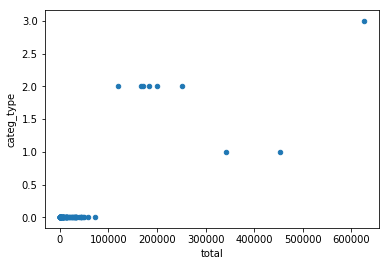

In [37]:
categ_types['total'] = categ_types.iloc[:, 1:12].sum(axis=1)
categ_types.plot.scatter(x='total', y='categ_type')